Need to upload:
* shape_predictor_81_face_landmarks.dat
* mask_detect.h5
* recognize_people5.

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
!pip install keras_facenet
import cv2
import os
from keras_facenet import FaceNet
import dlib
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import zipfile
import os

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.1 MB/s eta 0:00:00
  Created wheel for keras_facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=c5868a99f39f221da28f5c39ae047be8c32c67e4e07cdfdeb48b32f28043a9ff
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras_facenet


In [ ]:
recognize_model = load_model("recognize_people5.h5")
loaded_model = load_model("mask_detect.h5")


In [ ]:
def face_detector(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_classifier = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml'))
    scale = 4.0
    faces = face_classifier.detectMultiScale(gray_img, scale, 5)

    if len(faces) > 0:
      for (x, y, w, h) in faces:
          roi = img[y:y+h, x:x+w]
          return roi
    if len(faces) <= 0:
      scale = scale - 0.1
      while scale > 1.1:
        faces = face_classifier.detectMultiScale(gray_img, scale, 5)
        if len(faces) > 0:
          for (x, y, w, h) in faces:
              roi = img[y:y+h, x:x+w]
              return roi
        scale = scale - 0.1


    return None


In [ ]:
embedder = FaceNet()

def get_embeddings(face_img_path):
    face_img = cv2.imread(face_img_path)
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    yhat = embedder.embeddings(face_img)
    return yhat[0]

In [ ]:
def mask_detector(roi_img):
    resized_roi_img = cv2.resize(roi_img, (224, 224))
    normalized_roi_img = resized_roi_img / 255.0
    img_for_prediction = normalized_roi_img.reshape(1, 224, 224, 3)
    mask_prediction = loaded_model.predict(img_for_prediction)
    result = np.argmax(mask_prediction)
    if result == 0:
        # cv2.putText(img, 'Mask Detected', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        upper_face_roi = extract_forehead_face(roi_img)

        return upper_face_roi

    else:
        # cv2.putText(img, 'No Mask Detected', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        print("no")
        return roi_img


In [ ]:
predictor = dlib.shape_predictor("shape_predictor_81_face_landmarks.dat")

def extract_forehead_face(img):
    x,y =img.shape[0], img.shape[1]
    dlib_rect = dlib.rectangle(1,1,x-1,y-1)
    landmarks = predictor(img, dlib_rect)

    forehead_face_roi = np.array([
        (landmarks.part(20).x, landmarks.part(20).y),  # Left brow
        (landmarks.part(25).x, landmarks.part(25).y),
        (landmarks.part(70).x, landmarks.part(70).y),  # Right brow
        (landmarks.part(71).x, landmarks.part(71).y),
        (landmarks.part(1).x, landmarks.part(1).y),    # Left side
        (landmarks.part(17).x, landmarks.part(17).y),  # Right side
        (landmarks.part(16).x, landmarks.part(16).y),
        (landmarks.part(6).x, landmarks.part(16).y),
        (landmarks.part(42).x, landmarks.part(42).y),  # Left eye bottom
        (landmarks.part(47).x, landmarks.part(47).y),  # Right eye bottom
    ], dtype=np.int32)

    x, y, w, h = cv2.boundingRect(forehead_face_roi)
    new_y = max(0, int(y - 0.2 * h))
    new_h = int(h + 0.1 * h)
    forehead_face = img[new_y:new_y + new_h, x:x + w]

    return forehead_face




In [ ]:
valid_labels = ['Emilka', 'Julka', 'Kacper', 'Kaja', 'Karolina', 'Kuba', 'Maciek', 'Madzia', 'Ola', 'Sylwia', 'Szczepan']
def recognize_person(img_path, confidence_threshold=0.70):
    test_img = cv2.imread(img_path)
    roi = face_detector(test_img)

    if roi is not None:
        pred = mask_detector(roi)
        # cv2_imshow(pred)
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        cv2.imwrite("/content/result.jpg", pred)

        emb = get_embeddings("/content/result.jpg")
        emb = np.expand_dims(emb, axis=0)
        prediction = recognize_model.predict(emb)

        max_prob = np.max(prediction)
        predicted_class_index = np.argmax(prediction)

        if max_prob >= confidence_threshold:
            predicted_class = valid_labels[predicted_class_index]
            plt.title(predicted_class)
            print(f'Predicted Class: {predicted_class}')
            print(f'Max Probability: {max_prob}')
            return predicted_class, max_prob
        else:
            plt.title("Unknown")
            print(f'Not confident enough. Predicted Class: Unknown')
            print(f'Max Probability: {max_prob}')
            return("Unknown"), max_prob





In [ ]:
zip_path = '/content/TEST IMG-20240105T102245Z-001.zip'
output_directory = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_directory)


The zip file has been unpacked!


In [ ]:

folder_path = "/content/TEST IMG/Kacper/"

def show_result(folder_path):
  images = os.listdir(folder_path)

  fig, ax = plt.subplots(1, len(images), figsize=(15, 3))

  for i, img_name in enumerate(images):

      img = plt.imread(folder_path + img_name)
      title = recognize_person(folder_path + img_name)

      ax[i].imshow(img)
      ax[i].axis('off')
      ax[i].set_title(title)



  plt.tight_layout()
  plt.show()


1/1 [==============================] - 0s 61ms/step
no
1/1 [==============================] - 0s 25ms/step
Predicted Class: Madzia
Max Probability: 0.998023271560669
1/1 [==============================] - 0s 26ms/step
Predicted Class: Madzia
Max Probability: 0.9248234033584595
1/1 [==============================] - 0s 64ms/step
no
1/1 [==============================] - 0s 25ms/step
Predicted Class: Madzia
Max Probability: 0.9844865202903748
1/1 [==============================] - 0s 58ms/step
no
1/1 [==============================] - 0s 22ms/step
Predicted Class: Madzia
Max Probability: 0.9870489239692688
1/1 [==============================] - 0s 23ms/step
Predicted Class: Madzia
Max Probability: 0.9021280407905579
1/1 [==============================] - 0s 56ms/step
no
1/1 [==============================] - 0s 28ms/step
Predicted Class: Madzia
Max Probability: 0.9972852468490601


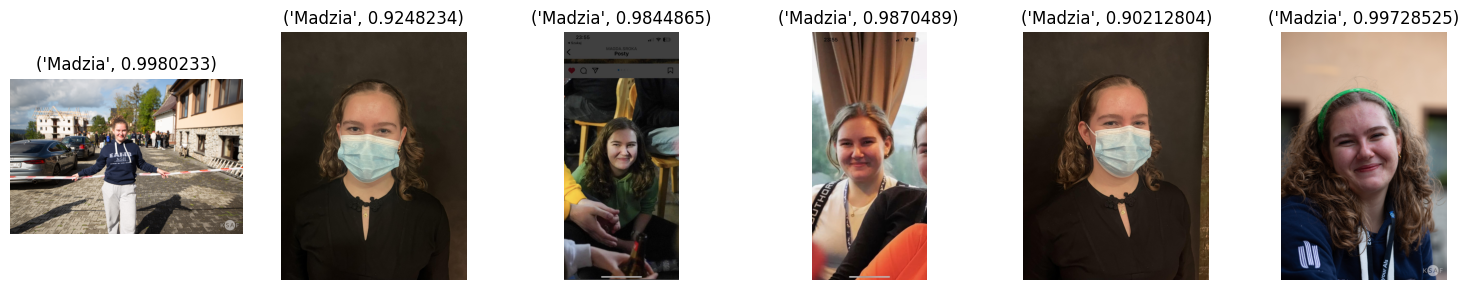

In [ ]:
show_result('/content/TEST IMG/Madzia/')

1/1 [==============================] - 0s 62ms/step
no
1/1 [==============================] - 0s 24ms/step
Predicted Class: Ola
Max Probability: 0.9978424310684204
1/1 [==============================] - 0s 24ms/step
Predicted Class: Ola
Max Probability: 0.9828553199768066
1/1 [==============================] - 0s 34ms/step
Predicted Class: Ola
Max Probability: 0.9122248291969299
1/1 [==============================] - 0s 64ms/step
no
1/1 [==============================] - 0s 25ms/step
Predicted Class: Ola
Max Probability: 0.9873566627502441


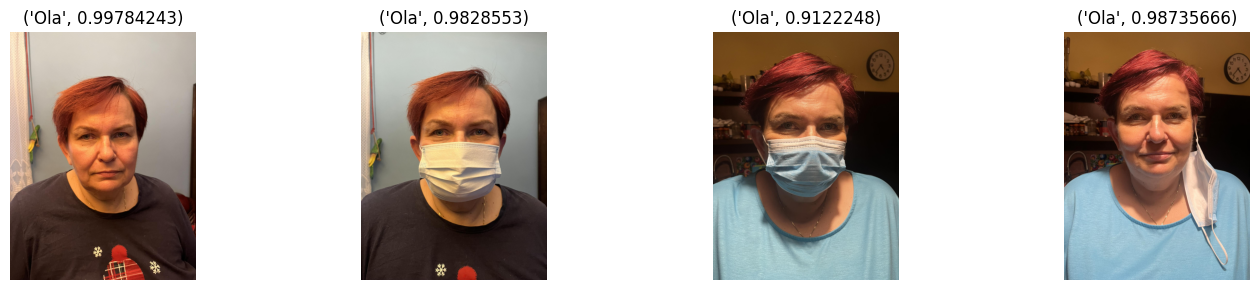

In [ ]:
show_result('/content/TEST IMG/Ola/')

1/1 [==============================] - 0s 59ms/step
no
1/1 [==============================] - 0s 32ms/step
Predicted Class: Kuba
Max Probability: 0.9849022030830383
1/1 [==============================] - 0s 27ms/step
Predicted Class: Kuba
Max Probability: 0.763349175453186
1/1 [==============================] - 0s 40ms/step
Predicted Class: Kuba
Max Probability: 0.9457242488861084
1/1 [==============================] - 0s 32ms/step
Not confident enough. Predicted Class: Unknown
Max Probability: 0.4963172972202301
1/1 [==============================] - 0s 105ms/step
no
1/1 [==============================] - 0s 38ms/step
Predicted Class: Kuba
Max Probability: 0.9879255294799805
1/1 [==============================] - 0s 56ms/step
no
1/1 [==============================] - 0s 31ms/step
Predicted Class: Kuba
Max Probability: 0.9943933486938477
1/1 [==============================] - 0s 42ms/step
Predicted Class: Kuba
Max Probability: 0.8590842485427856
1/1 [==============================] - 0

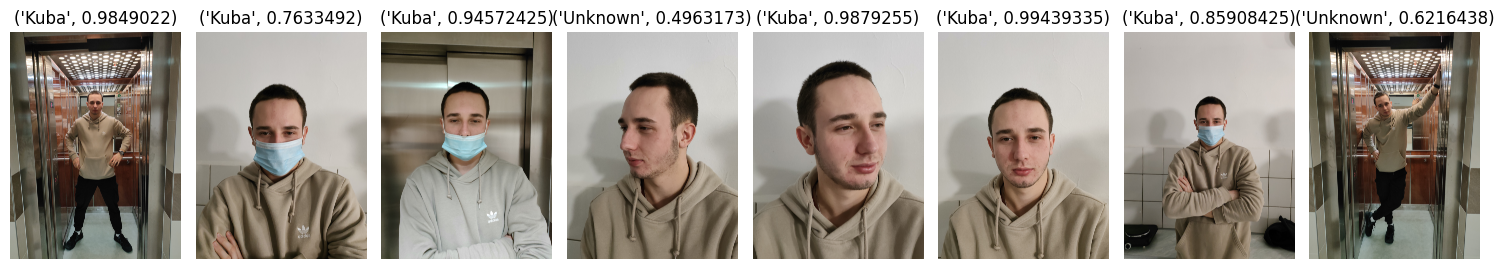

In [ ]:
show_result('/content/TEST IMG/Kuba/')

1/1 [==============================] - 0s 88ms/step
no
1/1 [==============================] - 0s 34ms/step
Predicted Class: Sylwia
Max Probability: 0.9467088580131531
1/1 [==============================] - 0s 25ms/step
Predicted Class: Sylwia
Max Probability: 0.9529880881309509
1/1 [==============================] - 0s 23ms/step
Predicted Class: Sylwia
Max Probability: 0.7328609824180603
1/1 [==============================] - 0s 88ms/step
no
1/1 [==============================] - 0s 34ms/step
Predicted Class: Sylwia
Max Probability: 0.9779608845710754


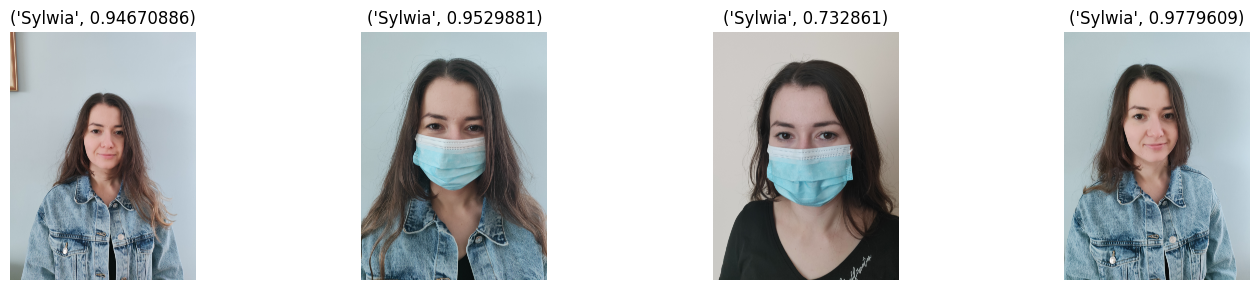

In [ ]:
show_result('/content/TEST IMG/Sylwia/')

1/1 [==============================] - 0s 58ms/step
no
1/1 [==============================] - 0s 82ms/step
Predicted Class: Maciek
Max Probability: 0.9979896545410156
1/1 [==============================] - 0s 58ms/step
no
1/1 [==============================] - 0s 22ms/step
Predicted Class: Maciek
Max Probability: 0.9866951704025269
1/1 [==============================] - 0s 55ms/step
no
1/1 [==============================] - 0s 23ms/step
Not confident enough. Predicted Class: Unknown
Max Probability: 0.44800621271133423
1/1 [==============================] - 0s 34ms/step
Predicted Class: Maciek
Max Probability: 0.9963452219963074
1/1 [==============================] - 0s 98ms/step
no
1/1 [==============================] - 0s 33ms/step
Predicted Class: Maciek
Max Probability: 0.9981697797775269


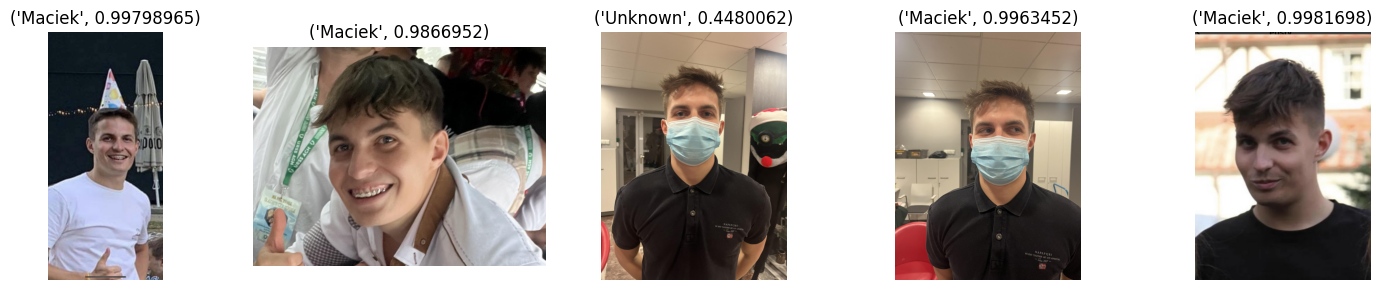

In [ ]:
show_result('/content/TEST IMG/Maciek/')

1/1 [==============================] - 0s 68ms/step
no
1/1 [==============================] - 0s 25ms/step
Predicted Class: Kaja
Max Probability: 0.9074143171310425
1/1 [==============================] - 0s 24ms/step
Predicted Class: Kaja
Max Probability: 0.9702771902084351
1/1 [==============================] - 0s 58ms/step
no
1/1 [==============================] - 0s 26ms/step
Predicted Class: Kaja
Max Probability: 0.9756853580474854
1/1 [==============================] - 0s 113ms/step
no
1/1 [==============================] - 0s 35ms/step
Predicted Class: Kaja
Max Probability: 0.9815840125083923


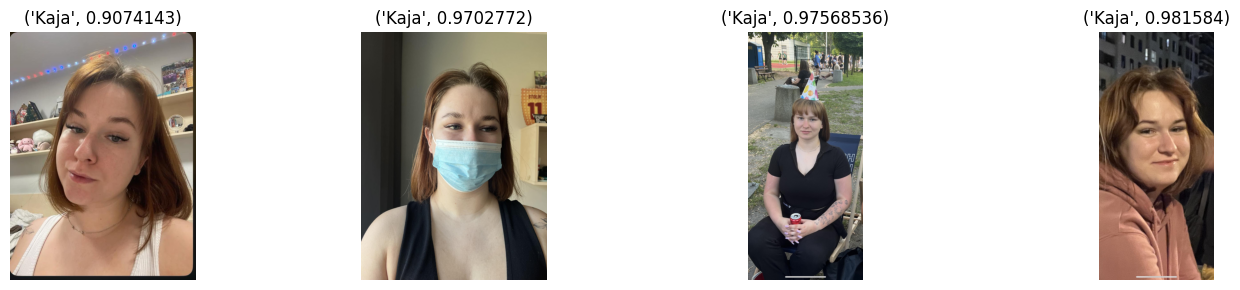

In [ ]:
show_result('/content/TEST IMG/Kaja/')

1/1 [==============================] - 0s 112ms/step
no
1/1 [==============================] - 0s 28ms/step
Predicted Class: Kacper
Max Probability: 0.9954835176467896
1/1 [==============================] - 0s 63ms/step
no
1/1 [==============================] - 0s 27ms/step
Predicted Class: Kacper
Max Probability: 0.9951607584953308
1/1 [==============================] - 0s 55ms/step
no
1/1 [==============================] - 0s 22ms/step
Predicted Class: Kacper
Max Probability: 0.9877521991729736
1/1 [==============================] - 0s 26ms/step
Predicted Class: Kacper
Max Probability: 0.7932294607162476
1/1 [==============================] - 0s 71ms/step
no
1/1 [==============================] - 0s 25ms/step
Not confident enough. Predicted Class: Unknown
Max Probability: 0.544477105140686
1/1 [==============================] - 0s 23ms/step
Predicted Class: Kacper
Max Probability: 0.9002906084060669
1/1 [==============================] - 0s 95ms/step
no
1/1 [=========================

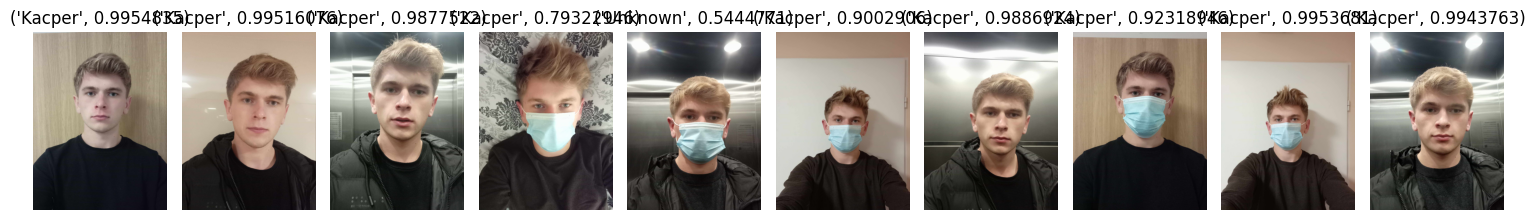

In [ ]:
show_result('/content/TEST IMG/Kacper_/')

1/1 [==============================] - 0s 60ms/step
no
1/1 [==============================] - 0s 22ms/step
Predicted Class: Karolina
Max Probability: 0.7811301350593567
1/1 [==============================] - 0s 25ms/step
Predicted Class: Karolina
Max Probability: 0.9381272196769714
1/1 [==============================] - 0s 73ms/step
no
1/1 [==============================] - 0s 24ms/step
Not confident enough. Predicted Class: Unknown
Max Probability: 0.5050821900367737
1/1 [==============================] - 0s 33ms/step
Predicted Class: Karolina
Max Probability: 0.7820032238960266
1/1 [==============================] - 0s 28ms/step
Not confident enough. Predicted Class: Unknown
Max Probability: 0.4883885085582733
1/1 [==============================] - 0s 36ms/step
Predicted Class: Karolina
Max Probability: 0.8807924389839172


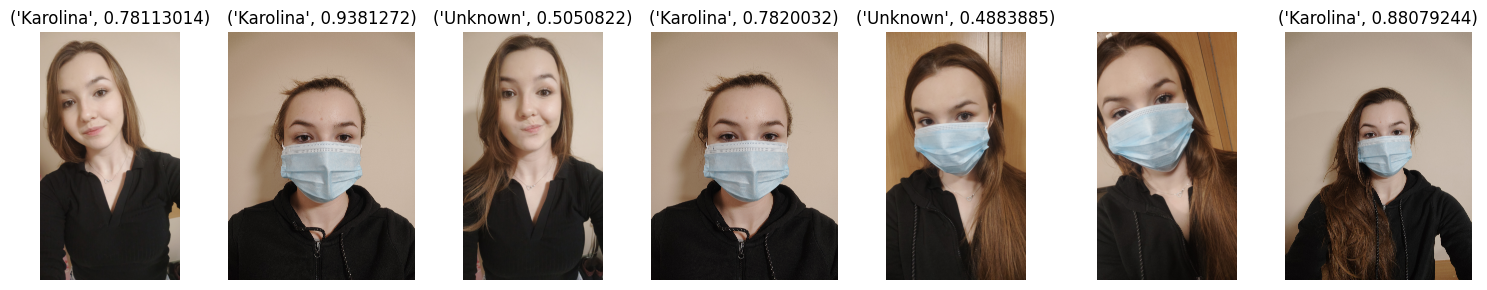

In [ ]:
show_result('/content/TEST IMG/Karo/')

1/1 [==============================] - 0s 101ms/step
no
1/1 [==============================] - 0s 31ms/step
Predicted Class: Szczepan
Max Probability: 0.9228662848472595
1/1 [==============================] - 0s 99ms/step
no
1/1 [==============================] - 0s 38ms/step
Predicted Class: Julka
Max Probability: 0.7633510828018188
1/1 [==============================] - 0s 66ms/step
no
1/1 [==============================] - 0s 26ms/step
Predicted Class: Szczepan
Max Probability: 0.9685938954353333
1/1 [==============================] - 0s 24ms/step
Not confident enough. Predicted Class: Unknown
Max Probability: 0.5824399590492249
1/1 [==============================] - 0s 25ms/step
Not confident enough. Predicted Class: Unknown
Max Probability: 0.6771337985992432
1/1 [==============================] - 0s 25ms/step
Predicted Class: Szczepan
Max Probability: 0.8492133021354675


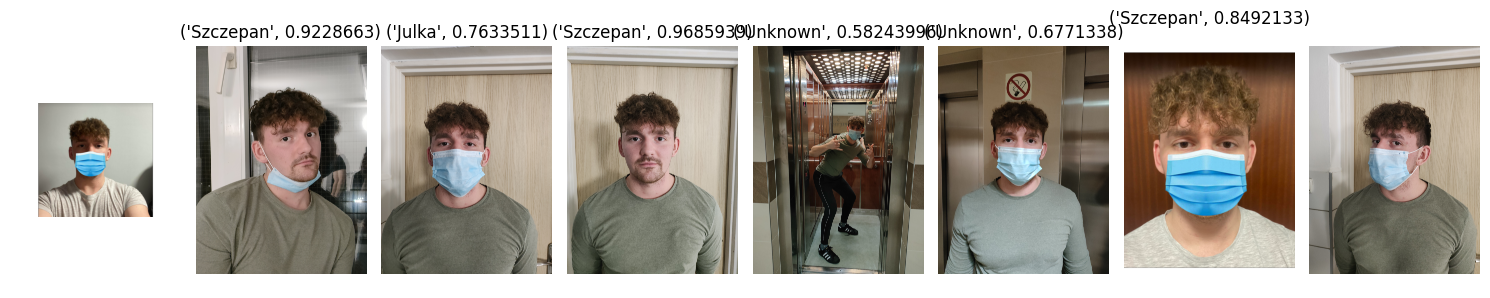

In [ ]:
show_result('/content/TEST IMG/Szczepan_/')

1/1 [==============================] - 0s 26ms/step
Not confident enough. Predicted Class: Unknown
Max Probability: 0.7484028339385986
1/1 [==============================] - 0s 31ms/step
Not confident enough. Predicted Class: Unknown
Max Probability: 0.5563783645629883
1/1 [==============================] - 0s 61ms/step
no
1/1 [==============================] - 0s 24ms/step
Predicted Class: Julka
Max Probability: 0.9550546407699585
1/1 [==============================] - 0s 62ms/step
no
1/1 [==============================] - 0s 24ms/step
Predicted Class: Julka
Max Probability: 0.8745222687721252


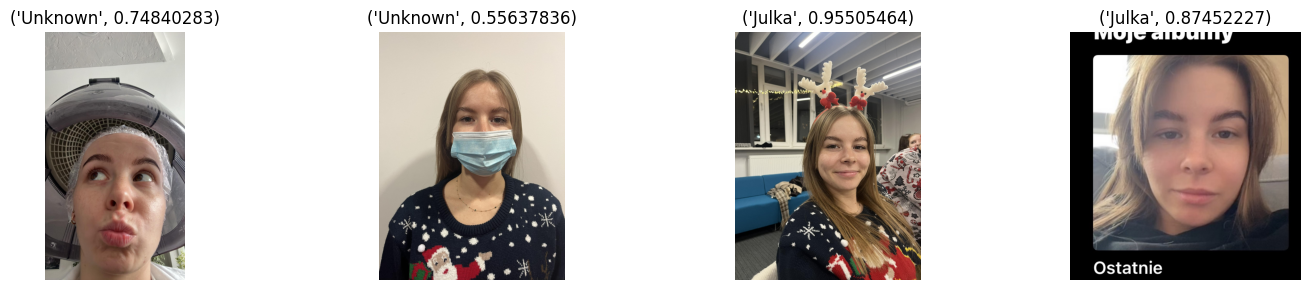

In [ ]:
show_result('/content/TEST IMG/Julka/')